In [1]:
!pip install datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import sqlglot
from sqlglot import expressions
from trl import SFTTrainer
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, pipeline, BitsAndBytesConfig

In [3]:
def parse_schema(sql_context):
    dialects = ["sqlite", "mysql", "postgres"]
    schema = {}

    # Preprocess sql_context to split statements and filter CREATE TABLE
    statements = [s.strip() for s in sql_context.split(";") if s.strip()]
    create_statements = [s for s in statements if s.upper().startswith("CREATE TABLE")]

    if not create_statements:
        print(f"No CREATE TABLE statements found in: {sql_context[:100]}...")
        return {}

    for dialect in dialects:
        try:
            for stmt in create_statements:
                parsed = sqlglot.parse_one(stmt, read=dialect)
                if isinstance(parsed, expressions.Create) and isinstance(parsed.this, expressions.Table):
                    table_name = parsed.this.this
                    columns = []
                    schema_expr = parsed.expression
                    if isinstance(schema_expr, expressions.Schema):
                        for col in schema_expr.expressions:
                            if isinstance(col, expressions.ColumnDef):
                                col_name = col.this.this if isinstance(col.this, expressions.Identifier) else str(col.this)
                                columns.append(col_name)
                    schema[table_name] = columns
            return schema
        except Exception as e:
            print(f"Error parsing with {dialect}: {e}")
            continue

    print(f"Failed to parse schema with all dialects: {sql_context[:100]}...")
    return {}

In [4]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
dataset_name = "gretelai/synthetic_text_to_sql"

In [5]:
dataset = load_dataset(dataset_name)
valid_test_split = dataset['test'].train_test_split(train_size=0.9)
dataset['valid'] = valid_test_split['train']
dataset['test'] = valid_test_split['test']
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

(…)nthetic_text_to_sql_train.snappy.parquet:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

(…)ynthetic_text_to_sql_test.snappy.parquet:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5851 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 586
    })
    valid: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 5265
    })
})

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [7]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,  # or torch.float16 (fp16) if you prefer
    device_map="auto",
)

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # For TinyLlama-like architectures
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


In [9]:
def format_example(example):
        # Parse schema to extract tables and columns
        schema = parse_schema(example['sql_context'])
        schema_summary = "\n".join([f"Table {table}: {', '.join(cols)}" for table, cols in schema.items()]) or "No schema parsed."

        # Create a conversational prompt in ChatML format
        system_prompt = (
            "You are an SQL expert who explains SQL queries clearly. Given a database schema, a natural language query, "
            "and the corresponding SQL query, provide a step-by-step explanation of how the SQL query works."
        )
        user_prompt = (
            f"**User Question**: {example['sql_prompt']}\n"
            f"**Schema Overview**: {schema_summary}\n"
            f"**SQL Query**: {example['sql']}"
        )
        sql_explanation = (
            f"**SQL Query**: {example['sql_explanation']}"
        )

        return {
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
                {"role": "assistant", "content": sql_explanation}
            ]
        }

In [10]:
formatted_dataset = dataset.map(format_example)
formatted_dataset

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

No CREATE TABLE statements found in: CREATE VIEW ev_suvs AS SELECT * FROM green_vehicles WHERE type = 'Electric' AND category = 'SUV';...
No CREATE TABLE statements found in: SELECT p.name, c.claim_date, c.claim_amount FROM claims c JOIN policyholders p ON c.policyholder_id ...
No CREATE TABLE statements found in: language_revitalization (id, language, program_name, location, start_year, end_year)...
No CREATE TABLE statements found in: CREATE VIEW ev_prices AS SELECT gv.*, price FROM green_vehicles gv JOIN vehicle_prices vp ON gv.id =...
No CREATE TABLE statements found in: CREATE VIEW DroughtImpact AS SELECT region, impact_level FROM DroughtAssessments WHERE drought_sever...
No CREATE TABLE statements found in: CREATE VIEW europe_hotels AS SELECT * FROM hotels WHERE continent = 'Europe'; CREATE VIEW virtual_to...


No CREATE TABLE statements found in: EmployeeDemographics...
No CREATE TABLE statements found in: player (player_id, name, email, age, gender, country, total_games_played); game (game_id, name, genr...
No CREATE TABLE statements found in: DROP TABLE conditions;...
No CREATE TABLE statements found in: CREATE VIEW research_grants AS SELECT g.id, g.grant_name, g.amount, g.start_date, g.end_date, m.spec...
No CREATE TABLE statements found in: CREATE VIEW young_engineers AS SELECT * FROM engineers WHERE engineers.id < 5;...
No CREATE TABLE statements found in: CREATE VIEW vw_top_scorers AS SELECT * FROM (SELECT name, goals_scored, ROW_NUMBER() OVER (ORDER BY ...
No CREATE TABLE statements found in: Game_Design...
No CREATE TABLE statements found in: CREATE VIEW construction_projects AS SELECT permit_id FROM building_permits;...
No CREATE TABLE statements found in: CREATE VIEW cali_mitigation_projects AS SELECT name, budget FROM mitigation_projects WHERE location ...
No CREATE TABLE statemen

No CREATE TABLE statements found in: top_5_goal_scorers...
No CREATE TABLE statements found in: CREATE VIEW FarmersMarket AS SELECT * FROM Products WHERE is_organic = TRUE; INSERT INTO Products (i...
No CREATE TABLE statements found in: ARTIST(artist_id, name, gender)...
No CREATE TABLE statements found in: CREATE VIEW TOTAL_PRODUCTION AS SELECT SUM(PRODUCTION_QTY) FROM GAS_WELLS;...
No CREATE TABLE statements found in: ARTWORK(artwork_id, title, date_created, period, artist_id); ARTIST(artist_id, name, gender)...
No CREATE TABLE statements found in: ARTIST(artist_id, old_name, new_name)...
No CREATE TABLE statements found in: CREATE VIEW cruelty_free_products AS SELECT product_id, product_name FROM products WHERE cruelty_fre...
No CREATE TABLE statements found in: CREATE VIEW Eco_Friendly_Products AS SELECT product_id, product_name, environmental_impact_score FRO...
No CREATE TABLE statements found in: See context...
No CREATE TABLE statements found in: electric_vehicles...
No CREATE 

No CREATE TABLE statements found in: game_stats(player_id, game_id, score, date_played)...
No CREATE TABLE statements found in: CULTURAL_EVENTS(event_id, name, location, date, attendance)...
No CREATE TABLE statements found in: CREATE VIEW peacekeeping_view AS SELECT peacekeeping_operations.operation_name, peacekeeping_forces....
No CREATE TABLE statements found in: CREATE VIEW cultural_heritage AS SELECT * FROM historical_sites WHERE type = 'cultural_heritage';...
No CREATE TABLE statements found in: nato_equipment...
No CREATE TABLE statements found in: CREATE VIEW sales_data AS SELECT id, vehicle_type, avg_speed, sales FROM vehicle_sales WHERE sales >...
No CREATE TABLE statements found in: CREATE VIEW crop_temperature AS SELECT crops.crop_name, field_sensors.temperature, field_sensors.mea...
No CREATE TABLE statements found in: athlete_stats; athlete_demographics...
No CREATE TABLE statements found in: CREATE VIEW wastewater_treatment_plants AS SELECT w.plant_id, w.location, w.capa

No CREATE TABLE statements found in: CREATE VIEW sustainable_materials AS SELECT * FROM materials WHERE sustainable = 'yes';...
No CREATE TABLE statements found in: CREATE VIEW suburban_neighborhoods AS SELECT * FROM properties WHERE neighborhood_type = 'suburban';...
No CREATE TABLE statements found in: diversity_metrics...
No CREATE TABLE statements found in: Player_Demographics...
No CREATE TABLE statements found in: community_program (id, program_name, location, start_year, end_year, language, status)...
No CREATE TABLE statements found in: CREATE VIEW HabitatPreservation AS SELECT habitat_id, ranger_id FROM HabitatRangers; INSERT INTO Hab...
No CREATE TABLE statements found in: SELECT * FROM team_averages;...
No CREATE TABLE statements found in: CREATE VIEW habitat_preservation AS SELECT 'lion' AS animal_name, 250 AS acres_preserved UNION ALL S...
No CREATE TABLE statements found in: INSERT INTO claims (id, policyholder_id, claim_amount, claim_date) VALUES (6, 4, 4000, '2021-04-01

No CREATE TABLE statements found in: SELECT * FROM avg_games_by_team;...
No CREATE TABLE statements found in: bus_stops (id, name, city, country, issues)...
No CREATE TABLE statements found in: community_engagement (id, city, language, event_type, participants, event_date)...
No CREATE TABLE statements found in: shipments(shipment_id, load_date, unload_date, cargo_id, vessel_id, port_id, shipped_qty)...
No CREATE TABLE statements found in: CREATE VIEW WELL_COUNT AS SELECT COUNT(*), REGION FROM OIL_WELLS GROUP BY REGION;...
No CREATE TABLE statements found in: CREATE VIEW fish_summary AS SELECT species_name, conservation_status FROM fish_species...
No CREATE TABLE statements found in: CREATE SCHEMA if not exists gaming;...
No CREATE TABLE statements found in: CREATE VIEW crop_temperatures AS SELECT crops.crop_name, field_sensors.temperature, field_sensors.me...
No CREATE TABLE statements found in: CREATE VIEW europe_hotels AS SELECT * FROM hotels WHERE continent = 'Europe'; CREATE VIEW 

No CREATE TABLE statements found in: CREATE VIEW sales_data AS SELECT id, vehicle_type, avg_speed, sales FROM vehicle_sales WHERE sales >...
Error parsing with sqlite: Expecting ). Line 1, Col: 36.
  CREATE TABLE world_series ((match_id INT, athlete_id INT))
Error parsing with mysql: Expecting ). Line 1, Col: 36.
  CREATE TABLE world_series ((match_id INT, athlete_id INT))
Error parsing with postgres: Expecting ). Line 1, Col: 36.
  CREATE TABLE world_series ((match_id INT, athlete_id INT))
Failed to parse schema with all dialects: CREATE TABLE athletes (athlete_id INT, name VARCHAR(50), age INT, sport VARCHAR(50)); INSERT INTO at...
No CREATE TABLE statements found in: INSERT INTO products (product_id, name, supplier_id, quantity_sold, price) VALUES (1, 'Organic T-Shi...
No CREATE TABLE statements found in: CREATE VIEW best_selling_products AS SELECT * FROM products ORDER BY quantity_sold DESC LIMIT 5;...
No CREATE TABLE statements found in: CREATE VIEW recent_standards AS SELECT * FR

No CREATE TABLE statements found in: CREATE VIEW oceania_hotels AS SELECT * FROM hotels WHERE continent = 'Oceania'; CREATE VIEW virtual_...
No CREATE TABLE statements found in: Products (product_id, name, rating, cruelty_free)...
No CREATE TABLE statements found in: heritage_site (site_id, site_name, country)...
No CREATE TABLE statements found in: vessel_types...
No CREATE TABLE statements found in: MUSEUM_STORES(store_id, name, location, daily_revenue, date); DATES(date)...
No CREATE TABLE statements found in: INSERT INTO music_genres_ext (id, genre, popularity) VALUES (2, 'Jazz', 1500000);...
No CREATE TABLE statements found in: See context...
No CREATE TABLE statements found in: CREATE VIEW research_grants AS SELECT g.id, g.grant_name, g.amount, g.start_date, g.end_date, m.spec...
No CREATE TABLE statements found in: CREATE VIEW recent_sensor_data AS SELECT * FROM sensor_data WHERE date > DATE_SUB(NOW(), INTERVAL 1 ...
No CREATE TABLE statements found in: DELETE m FROM maintenance

No CREATE TABLE statements found in: endangered_language (language, status, total_speakers)...
No CREATE TABLE statements found in: CREATE VIEW chemical_inventory AS SELECT * FROM chemical_data;...
No CREATE TABLE statements found in: DELETE FROM suppliers WHERE supplier_id = 1;...
No CREATE TABLE statements found in: UPDATE vehicles SET last_maintenance = CURDATE() WHERE vehicle_id = 1;...
Error parsing with sqlite: Expecting ). Line 1, Col: 132.
  ers (id INT, paper_title VARCHAR(50), country VARCHAR(50), publication_date DATE), AIContinents (id INT, country VARCHAR(50), continent VARCHAR(50))
Error parsing with mysql: Expecting ). Line 1, Col: 132.
  ers (id INT, paper_title VARCHAR(50), country VARCHAR(50), publication_date DATE), AIContinents (id INT, country VARCHAR(50), continent VARCHAR(50))
Error parsing with postgres: Expecting ). Line 1, Col: 132.
  ers (id INT, paper_title VARCHAR(50), country VARCHAR(50), publication_date DATE), AIContinents (id INT, country VARCHAR(50), c

No CREATE TABLE statements found in: player (player_id, name, email, age, gender, country, total_games_played, join_date)...
No CREATE TABLE statements found in: mining_production(mine_id, product, production_quantity, production_date)...
No CREATE TABLE statements found in: SELECT * FROM policyholder_info;...
No CREATE TABLE statements found in: CREATE OR REPLACE VIEW health_equity_view AS SELECT * FROM health_equity;...
No CREATE TABLE statements found in: CREATE VIEW hotel_revenue AS SELECT h.hotel_id, h.hotel_name, h.city, h.country, SUM(r.revenue) AS t...
No CREATE TABLE statements found in: CREATE VIEW monthly_stats AS SELECT w.plant_id, w.location, w.capacity, SUM(t.volume) AS total_waste...
No CREATE TABLE statements found in: INSERT INTO claims (id, policyholder_id, claim_amount, claim_date) VALUES (7, 6, 2500, '2021-05-15')...
No CREATE TABLE statements found in: cargo(cargo_id, cargo_name, weight, volume, description)...
No CREATE TABLE statements found in: CREATE VIEW couri

No CREATE TABLE statements found in: CREATE VIEW labor_violations AS SELECT * FROM labor_stats WHERE fine > 5000;...
No CREATE TABLE statements found in: shipments(shipment_id, load_date, unload_date, cargo_id, vessel_id, port_id, shipped_qty)...
Error parsing with sqlite: Expecting ). Line 1, Col: 76.
  CREATE TABLE artists (id INT, name VARCHAR(255), age INT), festivals (id INT, artist_id INT, year INT)
Error parsing with mysql: Expecting ). Line 1, Col: 76.
  CREATE TABLE artists (id INT, name VARCHAR(255), age INT), festivals (id INT, artist_id INT, year INT)
Error parsing with postgres: Expecting ). Line 1, Col: 76.
  CREATE TABLE artists (id INT, name VARCHAR(255), age INT), festivals (id INT, artist_id INT, year INT)
Failed to parse schema with all dialects: CREATE TABLE artists (id INT, name VARCHAR(255), age INT), festivals (id INT, artist_id INT, year IN...
No CREATE TABLE statements found in: vessel_safety(vessel_id, safety_rating)...
No CREATE TABLE statements found in: tra

No CREATE TABLE statements found in: CREATE VIEW top_ethical_companies AS SELECT company_name, ethical_certification FROM ethical_manufac...
No CREATE TABLE statements found in: temperature_readings...


No CREATE TABLE statements found in: SELECT * FROM DiversityByGender;...
No CREATE TABLE statements found in: CREATE VIEW soldier_details AS SELECT id, name, branch FROM soldiers;...
No CREATE TABLE statements found in: CREATE VIEW ev_sedans AS SELECT * FROM green_vehicles WHERE type = 'Electric' AND category = 'Sedan'...
No CREATE TABLE statements found in: INSERT INTO policyholders (id, name, age, gender, policy_type, state) VALUES (4, 'Sara Connor', 28, ...
No CREATE TABLE statements found in: ALTER TABLE users ADD COLUMN region VARCHAR(50); UPDATE users SET region = 'United Kingdom' WHERE co...
No CREATE TABLE statements found in: trends(id, industry, innovation_trend, trend_impact)...
No CREATE TABLE statements found in: CREATE VIEW visit_age_group AS SELECT age, COUNT(*) AS count FROM visitor_demographics GROUP BY age;...
No CREATE TABLE statements found in: stations (id, name, city, country, latitude, longitude)...
No CREATE TABLE statements found in: Ingredients (ingredient_id,

No CREATE TABLE statements found in: CREATE VIEW animal_population AS SELECT 'Penguin' AS species, COUNT(*) AS num_animals FROM penguins ...
No CREATE TABLE statements found in: CREATE VIEW south_america_hotels AS SELECT * FROM hotels WHERE continent = 'South America'; CREATE V...
No CREATE TABLE statements found in: CREATE VIEW hotel_ratings AS SELECT h.hotel_id, h.hotel_name, h.city, h.country, AVG(r.rating) AS av...
No CREATE TABLE statements found in: CREATE VIEW FarmersMarket AS SELECT * FROM Products WHERE is_organic = TRUE; INSERT INTO Products (i...
No CREATE TABLE statements found in: diversity(id, startup_id, gender_diversity, ethnic_diversity)...
No CREATE TABLE statements found in: VESSEL(vessel_id, safety_record_id); SAFETY_INCIDENT(safety_record_id, incident_type)...
No CREATE TABLE statements found in: CREATE VIEW EmployeeAgesEthnicities AS SELECT Age, Ethnicity FROM EmployeeDemographics;...
No CREATE TABLE statements found in: CREATE SCHEMA music; USE music;...
Error pa

No CREATE TABLE statements found in: CREATE VIEW rural_neighborhoods AS SELECT * FROM properties WHERE neighborhood_type = 'rural';...
No CREATE TABLE statements found in: CREATE VIEW sustainable_urbanism AS SELECT properties.id, properties.city, SUM(properties.square_foo...
No CREATE TABLE statements found in: community_program (id, program_name, location, start_year, end_year, language, status)...
No CREATE TABLE statements found in: CREATE VIEW top_sustainable_suppliers AS SELECT * FROM suppliers ORDER BY sustainability_score DESC ...
No CREATE TABLE statements found in: vessel_performance(vessel_id, max_speed, average_speed)...
No CREATE TABLE statements found in: CREATE VIEW top_military_powers AS SELECT country_of_origin, COUNT(equipment_id) AS equipment_count ...
No CREATE TABLE statements found in: CREATE VIEW RuralCommunities AS SELECT program_id, location, attendee_count FROM CommunityPrograms W...


No CREATE TABLE statements found in: CREATE VIEW recent_harvest_data AS SELECT * FROM harvest_data WHERE date > DATE_SUB(NOW(), INTERVAL ...
No CREATE TABLE statements found in: CREATE VIEW city_hotels AS SELECT * FROM hotels WHERE city = 'New York';...
No CREATE TABLE statements found in: CREATE VIEW FarmersMarket AS SELECT * FROM Products WHERE is_organic = TRUE; INSERT INTO Products (i...
No CREATE TABLE statements found in: VESSEL(vessel_id, vessel_name); TRIP(voyage_id, trip_date, vessel_id, fuel_consumption)...
No CREATE TABLE statements found in: athlete_demographics...
No CREATE TABLE statements found in: game_stats(player_id, game_id, score, date_played)...
No CREATE TABLE statements found in: INSERT INTO Community_Engagement (id, location, event_name, date, attendees) VALUES (1, 'New York', ...
No CREATE TABLE statements found in: CREATE VIEW urban_neighborhoods AS SELECT * FROM properties WHERE neighborhood_type = 'urban';...
No CREATE TABLE statements found in: cars (id, ma

No CREATE TABLE statements found in: SAME AS ABOVE...
No CREATE TABLE statements found in: CREATE VIEW Transportation_Emissions AS SELECT product_id, product_name, transportation_emissions FR...
No CREATE TABLE statements found in: CREATE VIEW international_programs AS SELECT * FROM programs WHERE country = 'International';...
No CREATE TABLE statements found in: SELECT DISTINCT School FROM Teachers;...
No CREATE TABLE statements found in: CREATE VIEW ongoing_peacekeeping_operations AS SELECT * FROM peacekeeping_operations WHERE end_date ...
No CREATE TABLE statements found in: CREATE VIEW sales_data AS SELECT o.order_id, c.customer_gender, g.garment_size, g.garment_type, g.pr...


No CREATE TABLE statements found in: training_programs...
No CREATE TABLE statements found in: species_observations...
No CREATE TABLE statements found in: player (player_id, name, email, age, gender, country, total_games_played)...
No CREATE TABLE statements found in: diversity_metrics...


No CREATE TABLE statements found in: CREATE VIEW micro_mobility AS SELECT 'ebike' AS vehicle_type, COUNT(*) AS quantity UNION ALL SELECT ...
No CREATE TABLE statements found in: CREATE VIEW contract_summary AS SELECT company_name, COUNT(*) AS total_contracts, SUM(contract_value...
No CREATE TABLE statements found in: CREATE VIEW courier_performances AS SELECT courier_id, order_id, MAX(delivery_time) as slowest_deliv...
No CREATE TABLE statements found in: CREATE VIEW Education_Programs AS SELECT 'Eco_Warriors' AS program, 22000 AS budget UNION SELECT 'Na...
No CREATE TABLE statements found in: CREATE VIEW sales_data AS SELECT id, vehicle_type, avg_speed, sales FROM vehicle_sales WHERE sales >...
No CREATE TABLE statements found in: CREATE VIEW vessel_summary AS SELECT vessel_id, AVG(avg_speed) AS average_speed, SUM(fuel_efficiency...
No CREATE TABLE statements found in: CREATE VIEW Community_Education AS SELECT 'Future_Guardians' AS program, 14000 AS budget UNION SELEC...
No CREATE TAB

Map:   0%|          | 0/586 [00:00<?, ? examples/s]

No CREATE TABLE statements found in: CREATE VIEW OrganicProducts AS SELECT * FROM Products WHERE is_organic = TRUE; INSERT INTO Products ...
No CREATE TABLE statements found in: CREATE VIEW courier_performances AS SELECT courier_id, order_id, MIN(delivery_time) as fastest_deliv...
No CREATE TABLE statements found in: CREATE VIEW autonomous_testing AS SELECT vehicle_make VARCHAR(50), test_result VARCHAR(10) FROM safe...
No CREATE TABLE statements found in: CREATE VIEW sustainable_suppliers AS SELECT * FROM suppliers WHERE sustainability_score > 80;...


Map:   0%|          | 0/5265 [00:00<?, ? examples/s]

No CREATE TABLE statements found in: vessel_performance(vessel_id, max_speed, average_speed)...
No CREATE TABLE statements found in: CREATE VIEW sales_data AS SELECT id, vehicle_type, avg_speed, sales FROM vehicle_sales WHERE sales >...
No CREATE TABLE statements found in: artifacts(artifact_id, name, description, date_found, excavation_site_id); excavations(excavation_si...
No CREATE TABLE statements found in: CREATE VIEW total_inventory AS SELECT 'ebike' AS transportation_type, SUM(quantity) AS total FROM mi...
No CREATE TABLE statements found in: INSERT INTO music_genres_ext (id, genre, popularity) VALUES (3, 'Pop', 25000000);...
No CREATE TABLE statements found in: SAME AS ABOVE...
No CREATE TABLE statements found in: CREATE VIEW asia_hotels AS SELECT * FROM hotels WHERE continent = 'Asia'; CREATE VIEW online_travel_...
No CREATE TABLE statements found in: CREATE VIEW cbt_therapists AS SELECT therapist_id, name, specialization, experience FROM therapists ...
No CREATE TABLE stateme

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'messages'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'messages'],
        num_rows: 586
    })
    valid: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'messages'],
        num_rows: 5265
    })
})

In [11]:
def apply_chatml(example):
    return {"text": tokenizer.apply_chat_template(example["messages"], tokenize=False)}

In [12]:
processed_dataset = formatted_dataset.map(apply_chatml)
processed_dataset

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/586 [00:00<?, ? examples/s]

Map:   0%|          | 0/5265 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'messages', 'text'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'messages', 'text'],
        num_rows: 586
    })
    valid: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'messages', 'text'],
        num_rows: 5265
    })
})

In [13]:
def formatting_prompts_func(example):
  return example["text"]

In [14]:
training_args = TrainingArguments(
    output_dir="./tinyllama-sql-explainer-full",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=3,
    warmup_steps=100,  # Added for training stability
    eval_strategy="steps",
    save_strategy="epoch",  # Save at epoch ends
    logging_steps=100,
    eval_steps=100,
    per_device_eval_batch_size=16,  # Explicitly set
    optim="adamw_torch",  # Explicit optimizer
    fp16=True,
    report_to="none"
)

In [15]:
trainer = SFTTrainer(
        model=model,
        train_dataset=processed_dataset['train'],
        eval_dataset=processed_dataset['valid'],
        formatting_func=formatting_prompts_func,  # Use formatting function
        args=training_args,
    )

Applying formatting function to train dataset:   0%|          | 0/100000 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/100000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/100000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/100000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/100000 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/5265 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/5265 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/5265 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/5265 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/5265 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [16]:
trainer.train()

Step,Training Loss,Validation Loss
100,1.077600,0.515694
200,0.483500,0.470379
300,0.456900,0.453350
400,0.446000,0.442873
500,0.437000,0.435298
600,0.429300,0.429028
700,0.426500,0.424674
800,0.421900,0.421061
900,0.415900,0.417074
1000,0.412900,0.414258


TrainOutput(global_step=4686, training_loss=0.4113140325998069, metrics={'train_runtime': 6657.4667, 'train_samples_per_second': 45.062, 'train_steps_per_second': 0.704, 'total_flos': 5.5506358076748595e+17, 'train_loss': 0.4113140325998069})

In [17]:
trainer.save_model("./tinyllama-sql-explainer-full")
tokenizer.save_pretrained("./tinyllama-sql-explainer-full")

('./tinyllama-sql-explainer-full/tokenizer_config.json',
 './tinyllama-sql-explainer-full/special_tokens_map.json',
 './tinyllama-sql-explainer-full/tokenizer.model',
 './tinyllama-sql-explainer-full/added_tokens.json',
 './tinyllama-sql-explainer-full/tokenizer.json')

In [18]:
!zip -r tinyllama-sql-explainer-full.zip tinyllama-sql-explainer-full/

  adding: tinyllama-sql-explainer-full/ (stored 0%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/ (stored 0%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/special_tokens_map.json (deflated 79%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/trainer_state.json (deflated 80%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/tokenizer_config.json (deflated 68%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/README.md (deflated 66%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/tokenizer.model (deflated 55%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/training_args.bin (deflated 51%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/scheduler.pt (deflated 55%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/tokenizer.json (deflated 85%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/scaler.pt (deflated 60%)
  adding: tinyllama-sql-explainer-full/checkpoint-3126/adapter_model.safetensors (deflated 7%)
  adding

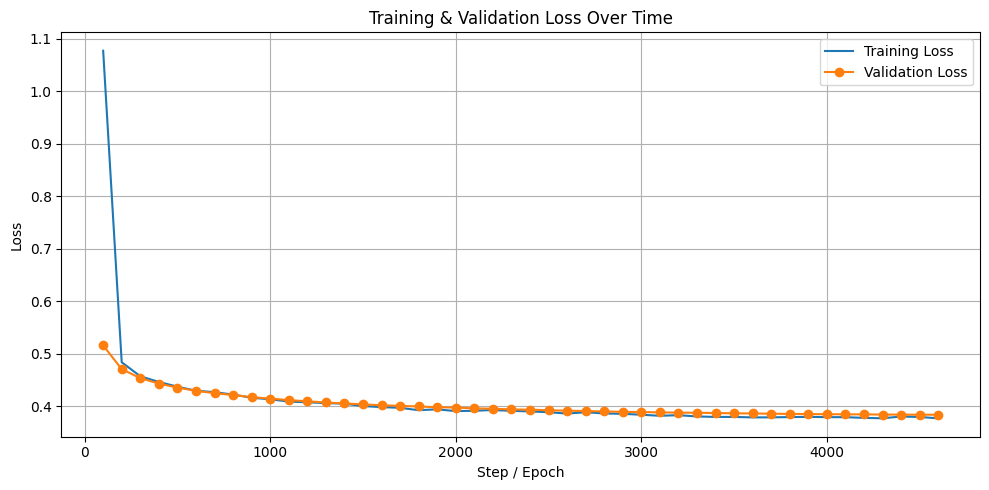

In [20]:
import matplotlib.pyplot as plt

# Get logs
logs = trainer.state.log_history

train_steps = []
train_losses = []
eval_epochs = []
eval_losses = []

for log in logs:
    if 'loss' in log and 'eval_loss' not in log:
        train_steps.append(log.get('step', log.get('epoch')))
        train_losses.append(log['loss'])
    elif 'eval_loss' in log:
        eval_epochs.append(log.get('step', log.get('epoch')))
        eval_losses.append(log['eval_loss'])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_losses, label="Training Loss")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker='o')
plt.xlabel("Step / Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("tinyllama_sql_explainer_loss_plot.png", dpi=300)
plt.show()

In [22]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoFo

In [53]:
def generate_explanation(schema, question, sql_query):
    schema = parse_schema(schema)
    schema_summary = "\n".join([f"Table {table}: {', '.join(cols)}" for table, cols in schema.items()]) or "No schema parsed."


    messages = [
      {
          "role": "system",
          "content": (
              "You are an SQL expert who explains SQL queries clearly. Given a database schema, a natural language query, "
              "and the corresponding SQL query, provide a step-by-step explanation of how the SQL query works."
          )
      },
      {
          "role": "user",
          "content": (
              f"**User Question**: {question}\n"
              f"**Schema Overview**: {schema_summary}\n"
              f"**SQL Query**: {sql_query}"
          )
      }
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(
      prompt,
      max_new_tokens=512,
      do_sample=True,
      temperature=0.7,
      top_k=50,
      top_p=0.95
    )
    return outputs[0]["generated_text"]

In [54]:
# Example inference
example_schema = (
    "CREATE TABLE employees (id INT, name VARCHAR(50), department VARCHAR(50), salary INT); "
    "CREATE TABLE departments (department VARCHAR(50), location VARCHAR(50));"
)
example_question = "Find the names and salaries of employees in the Engineering department."
example_sql = "SELECT name, salary FROM employees WHERE department = 'Engineering';"
response = generate_explanation(example_schema, example_question, example_sql)
print("\nExample Response:")
print(response)


Example Response:
<|system|>
You are an SQL expert who explains SQL queries clearly. Given a database schema, a natural language query, and the corresponding SQL query, provide a step-by-step explanation of how the SQL query works.</s>
<|user|>
**User Question**: Find the names and salaries of employees in the Engineering department.
**Schema Overview**: No schema parsed.
**SQL Query**: SELECT name, salary FROM employees WHERE department = 'Engineering';</s>
<|assistant|>
**SQL Query**: This SQL query selects the name and salary columns from the employees table where the department is 'Engineering'.


In [55]:
# Example inference
example_schema = """
CREATE TABLE salesperson (salesperson_id INT, name TEXT, region TEXT);
CREATE TABLE timber_sales (sales_id INT, salesperson_id INT, volume REAL, sale_date DATE);
"""
example_question = "List the names of salespeople in the North region."
example_sql = "SELECT name FROM salesperson WHERE region = 'North';"
response = generate_explanation(example_schema, example_question, example_sql)
print("\nExample Response:")
print(response)


Example Response:
<|system|>
You are an SQL expert who explains SQL queries clearly. Given a database schema, a natural language query, and the corresponding SQL query, provide a step-by-step explanation of how the SQL query works.</s>
<|user|>
**User Question**: List the names of salespeople in the North region.
**Schema Overview**: No schema parsed.
**SQL Query**: SELECT name FROM salesperson WHERE region = 'North';</s>
<|assistant|>
**SQL Query**: This SQL query retrieves the names of salespeople in the North region by selecting the 'name' column from the'salesperson' table where the'region' column is equal to 'North'.


In [56]:
# Example inference
example_schema = """
"""
example_question = "What is your name?"
example_sql = ""
response = generate_explanation(example_schema, example_question, example_sql)
print("\nExample Response:")
print(response)

No CREATE TABLE statements found in: 
...

Example Response:
<|system|>
You are an SQL expert who explains SQL queries clearly. Given a database schema, a natural language query, and the corresponding SQL query, provide a step-by-step explanation of how the SQL query works.</s>
<|user|>
**User Question**: What is your name?
**Schema Overview**: No schema parsed.
**SQL Query**: </s>
<|assistant|>
**SQL Query**: 1. Find all records in the 'Customers' table where the customer's name is 'John'. 2. Display the name of the customer.


In [57]:
response.split('<|assistant|>\n')[1].replace('**SQL Query**: ', '')

"1. Find all records in the 'Customers' table where the customer's name is 'John'. 2. Display the name of the customer."

In [58]:
processed_dataset['test'][0]['text'].split('<|assistant|>\n')[1].replace('**SQL Query**: ', '')

"The SQL query groups the 'investigative_reports' table by the 'author' column and then calculates the count of records for each group, which represents the number of articles published by each author.</s>\n"

In [59]:
processed_dataset['test'].select(range(100))

Dataset({
    features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'messages', 'text'],
    num_rows: 100
})

In [60]:
from tqdm import tqdm
predictions = []
references = []

for example in tqdm(processed_dataset['test'].select(range(100))):
    response = generate_explanation(example['sql_context'], example['sql_prompt'], example['sql'])
    predictions.append(response.split('<|assistant|>\n')[1].replace('**SQL Query**: ', ''))
    references.append(example['text'].split('<|assistant|>\n')[1].replace('**SQL Query**: ', ''))

  5%|▌         | 5/100 [00:15<05:01,  3.17s/it]
Exception ignored in: <function Dataset.__del__ at 0x793fab5feb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py", line 1413, in __del__
KeyboardInterrupt: 
Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/iostream.py", line 483, in flush
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/iostream.py", line 210, in schedule
    self._event_pipe.send(b"")
  File "/usr/local/lib/python3.11/dist-packages/zmq/sugar/socket.py", line 620, in send
    return super().send(data, flags=flags, copy=copy, track=track)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "zmq/backend/cython/socket.pyx", line 746, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 793, in zmq.backend.cython.socket.Socket.send
 

KeyboardInterrupt: 

In [42]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00


In [43]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=bbb2f5fca1f38995248ff65eeda628d0c0f01e9cf909f9f3082efb3e53b7d025
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [44]:
import evaluate

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

In [45]:
bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
print("BLEU:", bleu_score)

BLEU: {'bleu': 0.3418247813878791, 'precisions': [0.6032289628180039, 0.39844533600802406, 0.3109567901234568, 0.2510559662090813], 'brevity_penalty': 0.9235771162723558, 'length_ratio': 0.92635395422615, 'translation_length': 4088, 'reference_length': 4413}


In [46]:
rouge_score = rouge.compute(predictions=predictions, references=references)
print("ROUGE:", rouge_score)

ROUGE: {'rouge1': np.float64(0.6349182975319327), 'rouge2': np.float64(0.44363324562648415), 'rougeL': np.float64(0.5467430901690555), 'rougeLsum': np.float64(0.5460279442682672)}


# Inferencing

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from peft import PeftModel
import sqlglot
import torch
from sqlglot import expressions

base_model = AutoModelForCausalLM.from_pretrained(
        "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
        device_map="auto",
        torch_dtype=torch.bfloat16
)

model = PeftModel.from_pretrained(base_model, 'tinyllama-sql-explainer-full/')
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

In [5]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoFo

In [3]:
def parse_schema(sql_context):
    dialects = ["sqlite", "mysql", "postgres"]
    schema = {}

    # Preprocess sql_context to split statements and filter CREATE TABLE
    statements = [s.strip() for s in sql_context.split(";") if s.strip()]
    create_statements = [s for s in statements if s.upper().startswith("CREATE TABLE")]

    if not create_statements:
        print(f"No CREATE TABLE statements found in: {sql_context[:100]}...")
        return {}

    for dialect in dialects:
        try:
            for stmt in create_statements:
                parsed = sqlglot.parse_one(stmt, read=dialect)
                if isinstance(parsed, expressions.Create) and isinstance(parsed.this, expressions.Table):
                    table_name = parsed.this.this
                    columns = []
                    schema_expr = parsed.expression
                    if isinstance(schema_expr, expressions.Schema):
                        for col in schema_expr.expressions:
                            if isinstance(col, expressions.ColumnDef):
                                col_name = col.this.this if isinstance(col.this, expressions.Identifier) else str(col.this)
                                columns.append(col_name)
                    schema[table_name] = columns
            return schema
        except Exception as e:
            print(f"Error parsing with {dialect}: {e}")
            continue

    print(f"Failed to parse schema with all dialects: {sql_context[:100]}...")
    return {}

In [4]:
def generate_explanation(schema, question, sql_query):
    schema = parse_schema(schema)
    schema_summary = "\n".join([f"Table {table}: {', '.join(cols)}" for table, cols in schema.items()]) or "No schema parsed."


    messages = [
      {
          "role": "system",
          "content": (
              "You are an SQL expert who explains SQL queries clearly. Given a database schema, a natural language query, "
              "and the corresponding SQL query, provide a step-by-step explanation of how the SQL query works."
          )
      },
      {
          "role": "user",
          "content": (
              f"**User Question**: {question}\n"
              f"**Schema Overview**: {schema_summary}\n"
              f"**SQL Query**: {sql_query}"
          )
      }
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(
      prompt,
      max_new_tokens=512,
      do_sample=True,
      temperature=0.7,
      top_k=50,
      top_p=0.95
    )
    return outputs[0]["generated_text"]

In [6]:
# Example inference
example_schema = """
CREATE TABLE salesperson (salesperson_id INT, name TEXT, region TEXT);
CREATE TABLE timber_sales (sales_id INT, salesperson_id INT, volume REAL, sale_date DATE);
"""
example_question = "List the names of salespeople in the North region."
example_sql = "SELECT name FROM salesperson WHERE region = 'North';"
response = generate_explanation(example_schema, example_question, example_sql)
print("\nExample Response:")
print(response)


Example Response:
<|system|>
You are an SQL expert who explains SQL queries clearly. Given a database schema, a natural language query, and the corresponding SQL query, provide a step-by-step explanation of how the SQL query works.</s>
<|user|>
**User Question**: List the names of salespeople in the North region.
**Schema Overview**: No schema parsed.
**SQL Query**: SELECT name FROM salesperson WHERE region = 'North';</s>
<|assistant|>
**SQL Query**: This query selects the names of salespeople in the North region by selecting the 'name' column from the'salesperson' table where the'region' column is equal to 'North'.


In [7]:
response.split('<|assistant|>\n')[1].replace('**SQL Query**: ', '')

"This query selects the names of salespeople in the North region by selecting the 'name' column from the'salesperson' table where the'region' column is equal to 'North'."